# Lista 1 - Deep Learning

Humberto Navarro - 20190029131

Lara Pontes - 20190031550

Tales Nobre - 20200025983

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

## Questão 4

Utilize a rede neural perceptron de múltiplas camadas para fazer a predição de um passo,
até predição de três passos, da série temporal: x(n) = sen2(n) + cos(n+cos(n)). Avalie o
desempenho mostrando para cada caso os erros de predição.

Dica: Para auxiliar na resolução desse problema você pode usar K entradas (por exemplo,
K=10), que correspondem a K passos anteriores a n: x(n-1), x(n-2),..., x(n-K), e deve fazer a
predição dos valores x(n+1), x(n+2) e x(n+3)

Exemplo de treinamento 1:
Entrada: x(0), x(1), x(2)..., x(9)
Saída desejada: x(10), x(11) e x(12)

Exemplo de treinamento 2:
Entrada: x(1), x(2), x(3)..., x(10)
Saída desejada: x(11), x(12) e x(13)

Exemplo de treinamento n:
Entrada: x(20), x(21), x(22)..., x(29)
Saída desejada: x(30), x(31) e x(32)

### Criando o Dataset

In [3]:
def f(x):
    return np.sin(x)**2 + np.cos(x + np.cos(x))

In [4]:
X = np.linspace(-10, 10, 5000)
y = f(X)

In [5]:
data = pd.DataFrame([X, y]).T
data.columns = ['X', 'y']
data

,X,y
0,-10.000000,0.140094
1,-9.995999,0.134640
2,-9.991998,0.129186
3,-9.987998,0.123733
4,-9.983997,0.118281
...,...,...
4995,9.983997,-0.677230
4996,9.987998,-0.675350
4997,9.991998,-0.673424
4998,9.995999,-0.671453


In [6]:
data['y'].describe()[['min', 'max']]

min   -0.715771
max    1.605290
Name: y, dtype: float64

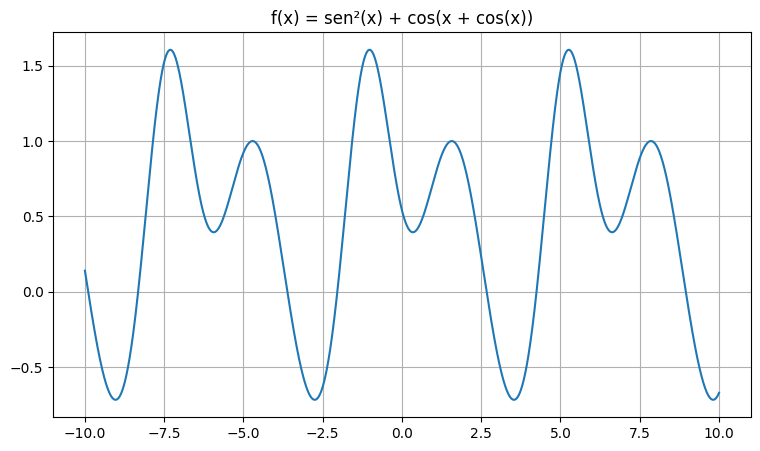

In [7]:
plt.figure(figsize=(9, 5))
plt.plot(X, y)
plt.grid()
plt.title('f(x) = sen²(x) + cos(x + cos(x))');

In [8]:
new_x = [y[i:i+10] for i in range(len(X) - 11)]
new_x[:2]

[array([0.1400943 , 0.13464   , 0.12918623, 0.12373321, 0.11828116,
        0.11283029, 0.10738081, 0.10193295, 0.09648692, 0.09104292]),
 array([0.13464   , 0.12918623, 0.12373321, 0.11828116, 0.11283029,
        0.10738081, 0.10193295, 0.09648692, 0.09104292, 0.08560119])]

In [9]:
new_y = [y[i:i+3] for i in range(10, len(X) - 11)]
new_y[:2]

[array([0.08560119, 0.08016193, 0.07472536]),
 array([0.08016193, 0.07472536, 0.06929168])]

In [10]:
new_data = pd.DataFrame([new_x, new_y]).T
new_data.columns = ['X', 'y']
new_data

,X,y
0,"[0.14009430196399966, 0.13463999987314323, 0.1...","[0.08560119230347576, 0.08016193158375473, 0.0..."
1,"[0.13463999987314323, 0.12918623073185045, 0.1...","[0.08016193158375473, 0.07472535681420728, 0.0..."
2,"[0.12918623073185045, 0.12373321106999, 0.1182...","[0.07472535681420728, 0.06929168165669142, 0.0..."
3,"[0.12373321106999, 0.1182811571644985, 0.11283...","[0.06929168165669142, 0.06386111944703968, 0.0..."
4,"[0.1182811571644985, 0.11283028503154596, 0.10...","[0.06386111944703968, 0.058433883188420965, 0...."
...,...,...
4984,"[-0.6948830484164027, -0.6935054658958228, -0....",None
4985,"[-0.6935054658958228, -0.6920827147712239, -0....",None
4986,"[-0.6920827147712239, -0.690614697683991, -0.6...",None
4987,"[-0.690614697683991, -0.6891013186203794, -0.6...",None


In [11]:
new_data.dropna(inplace=True)

### Criando a Rede Neural

In [12]:
X = torch.tensor(new_data[['X']].values[:, 0].tolist(), dtype=torch.float32)
y = torch.tensor(new_data['y'].values.tolist(), dtype=torch.float32)

#### Usando o teste como os 20% finais do dataset

In [13]:
perc = int(len(X)*.8)
X_train = X[:perc]
y_train = y[:perc]
X_test = X[perc:]
y_test = y[perc:]

In [14]:
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=32,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=32,
        shuffle=True
    )
}

In [15]:
class NeuralNet_(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet_, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.linear_stack(x)

In [16]:
model_ = NeuralNet_(10, 4, 3)
optimizer = optim.Adam(model_.parameters(), lr=5e-3)
loss_fn = nn.MSELoss()

In [17]:
train_loss_hist = []
test_loss_hist = []

epochs = 300

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    test_loss = []
    epoch_loss = []
    epoch_acc = []

    model_.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        output = model_(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)

    model_.eval()
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model_(data)
            mse = float(loss_fn(output, target))
            test_loss.append(mse)

    train_loss_hist.append(np.mean(epoch_loss))
    test_loss_hist.append(np.mean(test_loss))

    if epoch > 200:
        if np.mean(test_loss_hist[-75:]) >= np.mean(test_loss_hist[-150:-75]):
            print(f"\nAccuraccy of test set is not improving. Finishing training...")
            break
    if epoch > 50:
        if np.mean(test_loss_hist[:-40]) <= 0.001:
            print(f"\nAccuraccy of test set is good. Finishing training...")
            break

    print(f" Test set: Average loss: {np.mean(test_loss):.4f}") if epoch % 5 == 0 else None

Epoch [6/300]:   2%|▏         | 695/37500 [00:02<01:48, 340.52it/s, loss=0.001349]

 Test set: Average loss: 0.0012


Epoch [11/300]:   3%|▎         | 1301/37500 [00:04<01:58, 306.23it/s, loss=0.000528]

 Test set: Average loss: 0.0003


Epoch [16/300]:   5%|▌         | 1920/37500 [00:06<02:14, 264.99it/s, loss=0.000355]

 Test set: Average loss: 0.0003


Epoch [21/300]:   7%|▋         | 2553/37500 [00:08<02:12, 263.87it/s, loss=0.000153]

 Test set: Average loss: 0.0001


Epoch [26/300]:   8%|▊         | 3166/37500 [00:10<02:03, 277.24it/s, loss=0.000072]

 Test set: Average loss: 0.0001


Epoch [31/300]:  10%|█         | 3785/37500 [00:13<02:20, 240.38it/s, loss=0.000041]

 Test set: Average loss: 0.0001


Epoch [36/300]:  12%|█▏        | 4392/37500 [00:17<05:22, 102.59it/s, loss=0.000020]

 Test set: Average loss: 0.0000


Epoch [41/300]:  13%|█▎        | 5060/37500 [00:22<02:57, 183.18it/s, loss=0.000010]

 Test set: Average loss: 0.0000


Epoch [46/300]:  15%|█▌        | 5690/37500 [00:23<01:24, 374.68it/s, loss=0.000002]

 Test set: Average loss: 0.0000


Epoch [51/300]:  17%|█▋        | 6321/37500 [00:25<01:21, 384.23it/s, loss=0.000005]

 Test set: Average loss: 0.0000


Epoch [54/300]:  18%|█▊        | 6749/37500 [00:26<01:18, 392.63it/s, loss=0.000002]


Accuraccy of test set is good. Finishing training...


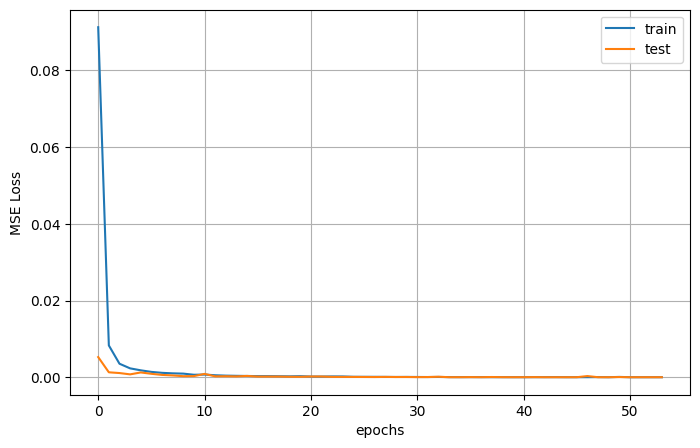

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid();

In [19]:
model_.eval()
with torch.no_grad():
    output = model_(X_test)

In [20]:
X_test[0]

tensor([0.9461, 0.9405, 0.9350, 0.9295, 0.9239, 0.9184, 0.9129, 0.9074, 0.9019,
        0.8965])

In [21]:
y_test[0]

tensor([0.8910, 0.8856, 0.8802])

In [22]:
output[0]

tensor([0.8900, 0.8835, 0.8802])

In [23]:
torch.sqrt(loss_fn(output, y_test))

tensor(0.0014)

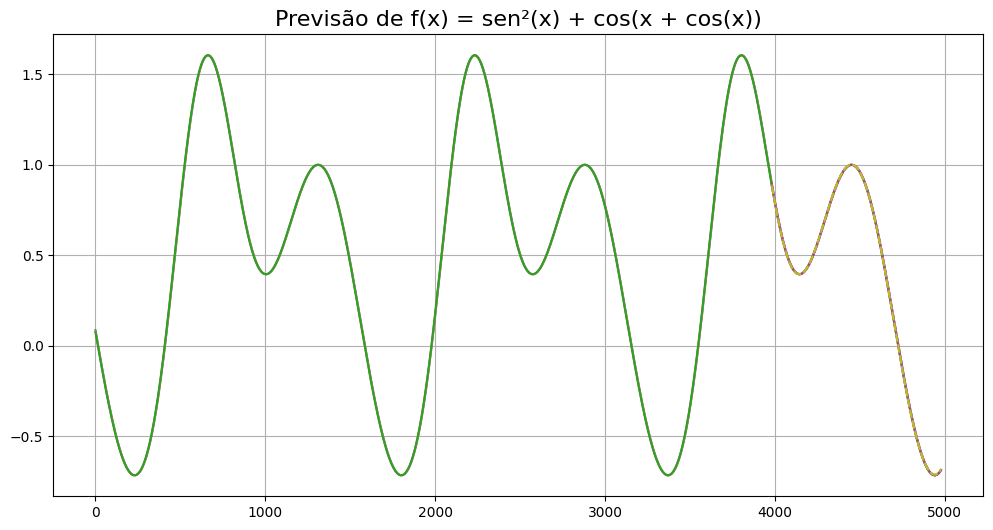

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(perc), y_train, label='train')

plt.plot(np.arange(perc, len(X)), y_test, '', label="test")
plt.plot(np.arange(perc, len(X)), output.detach(), '--', label="predict");
plt.title('Previsão de f(x) = sen²(x) + cos(x + cos(x))', fontsize=16)
plt.grid()

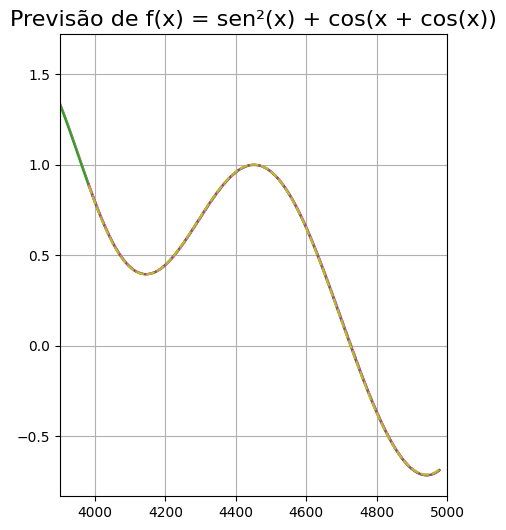

Epoch [54/300]:  18%|█▊        | 6750/37500 [00:40<01:18, 392.63it/s, loss=0.000002]

In [25]:
plt.figure(figsize=(5, 6))
plt.plot(np.arange(perc), y_train, label='train')

plt.plot(np.arange(perc, len(X)), y_test, label="test")
plt.plot(np.arange(perc, len(X)), output.detach(), '--', label="predict");
plt.title('Previsão de f(x) = sen²(x) + cos(x + cos(x))', fontsize=16)
plt.xlim(3900, 5000)
plt.grid()